In [1]:
import matplotlib
import tensorflow as tf
import random
import tensorflow_datasets as tfds
import sklearn.metrics as sk_metrics
from matplotlib import pyplot as plt
import tempfile
import os
import seaborn as sns
import numpy as np
from tensorflow import keras

In [2]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

tf.random.set_seed(22)
random.seed(a=22)

In [4]:
def read_data():
    with open("DATA.txt") as f:
        lines = f.readlines()

    input_data = np.empty(shape=(lines.__len__(), 2))
    for i in range(lines.__len__()):
        raw_data = lines[i].split(",")
        data0 = float(raw_data[0])
        data1 = float(raw_data[1])
        input_data[i][0] = data0
        input_data[i][1] = data1

    with open("TARGETS.txt") as f:
        lines = f.readlines()

    target_data = []
    for j in range(lines.__len__()):
        raw_line = lines[j].split(",")
        raw_data = []
        for k in range(raw_line.__len__()):
            raw_data.append(int(raw_line[k]))
        target_data.append(raw_data)

    return input_data, np.array(target_data)

In [5]:
def plot_data(data, title):
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    for aux in range(data.__len__()):
        points = data[aux]
        plt.plot(points[0], points[1], marker="o", markersize=5, markeredgecolor=points[2], markerfacecolor=points[2])
    # plt.scatter(x_data, y_data)
    plt.show()

In [6]:
def read_input():
    print(
        "Please insert the learning rate, percentage of data reserved for training, percentage for validation, max epochs, neurons in hidden layer, early stop\n")
    print("Learning rate: ")
    try:
        learning = float(input())
    except ValueError:
        raise TypeError("Expected Float, got wrong type!\n")
    print("Percentage of data reserved: ")
    try:
        reserved = float(input())
    except ValueError:
        raise TypeError("Expected Float, got wrong type!\n")
    print("Percentage of data for validation: ")
    try:
        reserved_validation = float(input())
    except ValueError:
        raise TypeError("Expected Float, got wrong type!\n")
    print("Max epochs: ")
    try:
        epochs = int(input())
    except ValueError:
        raise TypeError("Expected Int, got wrong type!\n")
    print("Neurons in hidden layer: ")
    try:
        neurons = int(input())
    except ValueError:
        raise TypeError("Expected Int, got wrong type!\n")
    print("Error rate used as stop condition (100 - 0)")
    try:
        error_rate = float(input())
    except ValueError:
        raise TypeError("Expected Float, got wrong type!\n")

    return learning, reserved, epochs, reserved_validation, neurons, error_rate

In [7]:
def select_training_data(data_to_sort_through, target_data_to_sort_through, samples):
    result = np.empty(shape=(samples, 2))
    target_result = np.empty(shape=(samples, 3))
    data_not_chosen = np.empty(shape=((data_to_sort_through.shape[0] - samples), 2))
    target_data_not_chosen = np.empty(shape=((data_to_sort_through.shape[0] - samples), 3))
    index_of_data_chosen = []
    for i in range(samples):
        new = True
        while new:
            line = random.randrange(0, data_to_sort_through.__len__() - 1, 1)
            possible_new_element0 = data_to_sort_through[line][0]
            possible_new_element1 = data_to_sort_through[line][1]
            temp = [possible_new_element0, possible_new_element1]
            if temp not in result:
                result[i][0] = possible_new_element0
                result[i][1] = possible_new_element1
                element = target_data_to_sort_through[line]
                target_result[i][0] = element[0]
                target_result[i][1] = element[1]
                target_result[i][2] = element[2]
                new = False
                index_of_data_chosen.append(line)
    aux = 0
    for j in range(data_to_sort_through.shape[0]):
        if j not in index_of_data_chosen:
            data_not_chosen[aux][0] = data_to_sort_through[j][0]
            data_not_chosen[aux][1] = data_to_sort_through[j][1]
            element = target_data_to_sort_through[j]
            target_data_not_chosen[aux][0] = element[0]
            target_data_not_chosen[aux][1] = element[1]
            target_data_not_chosen[aux][2] = element[2]
            aux += 1

    return np.array(result), np.array(target_result), np.array(data_not_chosen), np.array(target_data_not_chosen)

In [8]:
def prepare_data_for_plot(x_data, y_data):
    data_to_plot = []
    for u in range(learning_dataset.shape[0]):
        point = [learning_dataset[u][0], learning_dataset[u][1]]
        if np.array_equal(learning_target_dataset[u], [1, 0, 0]):
            point.append('green')
        elif np.array_equal(learning_target_dataset[u], [0, 1, 0]):
            point.append('red')
        elif np.array_equal(learning_target_dataset[u], [0, 0, 1]):
            point.append('blue')
        data_to_plot.append(point)
    return data_to_plot

In [9]:
def xavier_init(shape):
    in_dim, out_dim = shape
    xavier_lim = tf.sqrt(6.) / tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
    weight_vals = tf.random.uniform(shape=(in_dim, out_dim), minval=-xavier_lim, maxval=xavier_lim, seed=22)
    return weight_vals

In [10]:
class DenseLayer(tf.Module):
    def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
        super().__init__()
        self.out_dim = out_dim
        self.weight_init = weight_init
        self.activation = activation
        self.built = False

    def __call__(self, x):
        if not self.built:
            self.in_dim = x.shape[1]
            self.w = tf.Variable(xavier_init(shape=(self.in_dim, self.out_dim)))
            self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
            self.built = True
        z = tf.add(tf.matmul(x, self.w), self.b)
        return self.activation(z)

In [11]:
class ExportModule(tf.Module):
    def __init__(self, model, preprocess, class_pred):
        super().__init__()
        self.model = model
        self.preprocess = preprocess
        self.class_pred = class_pred

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)])
    def __call__(self, x):
        x = self.preprocess(x)
        y = self.model(x)
        y = self.class_pred(y)
        return y

In [12]:
class MLP(tf.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers

    @tf.function
    def __call__(self, x, preds=False):
        for layer in self.layers:
            x = layer(x)
        return x

In [13]:
class Adam:
    def __init__(self, rate_of_learning=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.learning_rate = rate_of_learning
        self.ep = ep
        self.t = 1.
        self.v_dvar, self.s_dvar = [], []
        self.built = False

    def apply_gradients(self, grads, vars):
        if not self.built:
            for var in vars:
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            self.v_dvar[i].assign(self.beta_1 * self.v_dvar[i] + (1 - self.beta_1) * d_var)
            self.s_dvar[i].assign(self.beta_2 * self.s_dvar[i] + (1 - self.beta_2) * tf.square(d_var))
            v_dvar_bc = self.v_dvar[i] / (1 - (self.beta_1 ** self.t))
            s_dvar_bc = self.s_dvar[i] / (1 - (self.beta_2 ** self.t))
            var.assign_sub(self.learning_rate * (v_dvar_bc / (tf.sqrt(s_dvar_bc) + self.ep)))
        self.t += 1.
        return

In [14]:
def cross_entropy_loss(y_pred, y):
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(sparse_ce)


def accuracy(y_pred, y):
    class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
    is_equal = tf.equal(y, class_preds)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))


def train_step(x_batch, y_batch, loss, acc, model, optimizer):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        batch_loss = loss(y_pred, y_batch)
    batch_acc = acc(y_pred, y_batch)
    grads = tape.gradient(batch_loss, model.variables)
    optimizer.apply_gradients(grads, model.variables)
    return batch_loss, batch_acc


def val_step(x_batch, y_batch, loss, acc, model):
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
    batch_acc = acc(y_pred, y_batch)
    return batch_loss, batch_acc


def class_pred_test(y):
    return tf.argmax(tf.nn.softmax(y), axis=1)

In [15]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        batch_losses_train, batch_accs_train = [], []
        batch_losses_val, batch_accs_val = [], []

        for x_batch, y_batch in train_data:
            batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
            batch_losses_train.append(batch_loss)
            batch_accs_train.append(batch_acc)

        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
            batch_losses_val.append(batch_loss)
            batch_accs_val.append(batch_acc)

        train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
        val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
        print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
    return train_losses, train_accs, val_losses, val_accs

In [16]:
def plot_metrics(train_metric, val_metric, metric_type):
    plt.figure()
    plt.plot(range(len(train_metric)), train_metric, label=f"Training {metric_type}")
    plt.plot(range(len(val_metric)), val_metric, label=f"Validation {metric_type}")
    plt.xlabel("Epochs")
    plt.ylabel(metric_type)
    plt.legend()
    plt.title(f"{metric_type} vs Training epochs")
    plt.show()


def accuracy_score(y_pred, y):
    is_equal = tf.equal(y_pred, y)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))


def show_confusion_matrix(test_labels, test_classes):
    plt.figure(figsize=(10, 10))
    confusion = sk_metrics.confusion_matrix(test_labels.numpy(), test_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1)
    axis_labels = range(10)
    ax = sns.heatmap(confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels, cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [17]:
x, y = read_data()

In [18]:
learning_rate, percentage_reserved, max_epochs, reserved_for_validation, hidden_neurons, acceptable_error = read_input()
n = int(percentage_reserved * x.__len__())

Please insert the learning rate, percentage of data reserved for training, percentage for validation, max epochs, neurons in hidden layer, early stop

Learning rate: 
Percentage of data reserved: 
Percentage of data for validation: 
Max epochs: 
Neurons in hidden layer: 
Error rate used as stop condition (100 - 0)


In [19]:
raw_learning_dataset, raw_learning_target_dataset, test_dataset, test_target_dataset = select_training_data(x, y, n)

In [20]:
amount_val_data = int(reserved_for_validation * raw_learning_dataset.__len__())

In [21]:
val_learning_dataset, val_learning_target_dataset, learning_dataset, learning_target_dataset = select_training_data(raw_learning_dataset, raw_learning_target_dataset, amount_val_data)

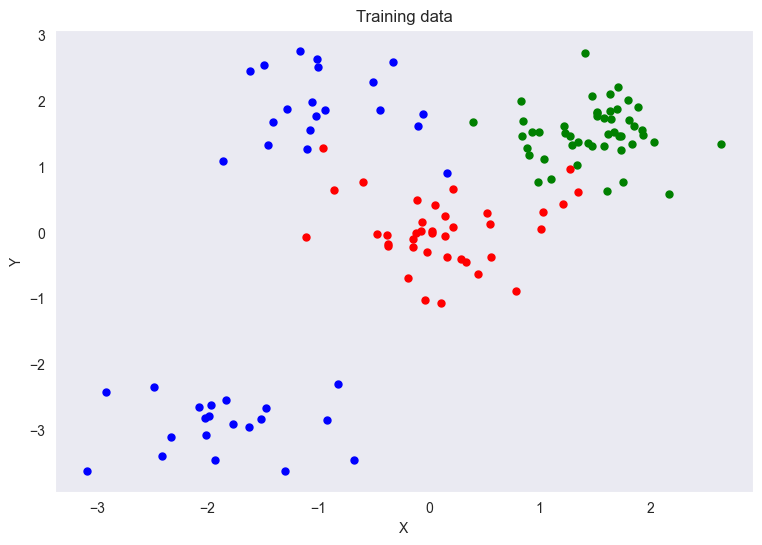

In [22]:
plot_data(prepare_data_for_plot(learning_dataset, learning_target_dataset), "Training data")

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((learning_dataset, learning_target_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((val_learning_dataset, val_learning_target_dataset))
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset, test_target_dataset))

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
output_size = 3

mlp_model = MLP([DenseLayer(out_dim=hidden_neurons, activation=tf.nn.relu), DenseLayer(out_dim=output_size)])

In [27]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_dataset, val_dataset, loss=cross_entropy_loss, acc=accuracy, optimizer=Adam(), epochs=max_epochs)

StagingError: in user code:

    File "C:\Users\vinic\AppData\Local\Temp\ipykernel_11188\3123083893.py", line 9, in __call__  *
        x = layer(x)
    File "C:\Users\vinic\AppData\Local\Temp\ipykernel_11188\3082772954.py", line 11, in __call__  *
        self.in_dim = x.shape[1]

    IndexError: tuple index out of range


In [24]:
model = keras.Sequential()
model.add(keras.Input(2,))
model.add(keras.layers.Dense(hidden_neurons, activation='relu'))
model.add(keras.layers.Dense(3, activation='relu'))

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.fit(learning_dataset, learning_target_dataset, epochs=1000, batch_size=64)

Epoch 1/1000
2/2 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3810
Epoch 2/1000
2/2 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3810
Epoch 3/1000
2/2 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3810
Epoch 4/1000
2/2 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3810
Epoch 5/1000
2/2 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.3810
Epoch 6/1000
2/2 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.3810
Epoch 7/1000
2/2 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.3810
Epoch 8/1000
2/2 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3810
Epoch 9/1000
2/2 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3810
Epoch 10/1000
2/2 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.3810
Epoch 11/1000
2/2 [==============================